# 第13章: GBDT入門 - LightGBM & XGBoost

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] LightGBMとXGBoostのScikit-learnラッパーが使える
- [ ] Early Stoppingで過学習を防げる
- [ ] 学習曲線を可視化してモデルの挙動を理解できる
- [ ] Scikit-learnのモデルとGBDTを比較できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 05（決定木とアンサンブル学習）
- ✅ Notebook 03（評価指標とクロスバリデーション）
- ✅ Notebook 02（前処理）

⏱️ **推定学習時間**: 90分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 機械学習・GBDT

---

## 🚀 GBDTとは？

**GBDT（Gradient Boosting Decision Tree）** は、Kaggleや実務で最も頻繁に使われる機械学習アルゴリズムです。

### なぜGBDTが「最強」と呼ばれるのか？

テーブルデータ（表形式データ）において、GBDTは：

1. **Kaggle上位入賞者の定番**: テーブルデータのコンペでは、ほぼ100%GBDTが使われる
2. **特徴量エンジニアリングとの相性**: 手作りの特徴量が性能に直結する
3. **解釈可能性**: Feature Importanceで「なぜその予測か」が分かる
4. **前処理が最小限**: 欠損値、スケーリング不要なケースが多い

### Boosting vs Bagging：何が違う？

```
┌─────────────────────────────────────────────────────────────────────┐
│                    アンサンブル学習の2大戦略                         │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【Bagging（Random Forest）】         【Boosting（GBDT）】          │
│                                                                     │
│  複数のモデルを「並列」で学習          複数のモデルを「順次」で学習  │
│                                                                     │
│      ┌─────┐                              ┌─────┐                   │
│      │木 1 │ ─┐                          │木 1 │                    │
│      └─────┘  │                          └──┬──┘                    │
│      ┌─────┐  │                             │ 残差を計算            │
│      │木 2 │ ─┼─→ 多数決/平均              ▼                       │
│      └─────┘  │                          ┌─────┐                    │
│      ┌─────┐  │                          │木 2 │ 残差を予測         │
│      │木 3 │ ─┘                          └──┬──┘                    │
│      └─────┘                                │                       │
│                                             ▼                       │
│  各木は独立                              ┌─────┐                    │
│  分散を減らす                            │木 3 │ さらに残差を予測   │
│  過学習に強い                            └──┬──┘                    │
│                                             │                       │
│                                             ▼                       │
│                                          最終予測 = 全木の合計      │
│                                                                     │
│                                          前の木の「間違い」を修正   │
│                                          バイアスを減らす           │
│                                          表現力が高い               │
└─────────────────────────────────────────────────────────────────────┘
```

### GBDTの学習アルゴリズム（直感的な説明）

GBDTは「**勾配降下法を木で表現したもの**」と考えると理解しやすいです：

```
【GBDTの学習プロセス】

Step 1: 最初の予測（単純な平均値など）
        予測値 = 0.5（例）
        
Step 2: 残差を計算
        残差 = 正解 - 予測値
        
        サンプル1: 正解=1, 予測=0.5 → 残差=+0.5（もっと上げたい）
        サンプル2: 正解=0, 予測=0.5 → 残差=-0.5（もっと下げたい）
        
Step 3: 残差を予測する木を学習
        木1は「どのサンプルをどれだけ修正すべきか」を学習
        
Step 4: 予測を更新
        新予測 = 旧予測 + 学習率 × 木1の予測
        
Step 5: Step 2-4を繰り返す
        木を追加するたびに、残った誤差を修正していく
```

**なぜ「勾配（Gradient）」なのか？**

損失関数を最小化するために、勾配（誤差の方向）を使って予測を更新します。
これは、深層学習で使われる勾配降下法と同じ考え方です。

### 代表的なGBDTライブラリ

| ライブラリ | 開発元 | 特徴 |
|-----------|--------|------|
| **LightGBM** | Microsoft | 高速・軽量・メモリ効率◎ |
| **XGBoost** | DMLC | 歴史が長く安定・分散処理◎ |
| **CatBoost** | Yandex | カテゴリ変数の扱いに優れる |

**選び方の目安**：
- 速度重視 → LightGBM
- 安定性重視 → XGBoost
- カテゴリ変数が多い → CatBoost（次章）

---

In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# LightGBM and XGBoost
try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    print("✅ LightGBM installed")
except ImportError:
    print("⚠️ LightGBM not installed. Run: pip install lightgbm")

try:
    import xgboost as xgb
    from xgboost import XGBClassifier
    print("✅ XGBoost installed")
except ImportError:
    print("⚠️ XGBoost not installed. Run: pip install xgboost")

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


✅ LightGBM installed
✅ XGBoost installed


#### 📦 必要なライブラリの読み込み

このセクションでは、分析に必要なPythonライブラリを読み込みます。

**主要ライブラリの役割**：
- **NumPy**: 数値計算の基盤（配列操作、数学関数）
- **Pandas**: データ操作と分析（表形式データの処理）
- **Matplotlib / Seaborn**: データ可視化（グラフ作成）
- **scikit-learn**: 機械学習アルゴリズムとツール
- **LightGBM**: Microsoft開発の高速GBDTライブラリ
- **XGBoost**: 高性能GBDTライブラリ

**注意**: LightGBMとXGBoostがインストールされていない場合は、以下のコマンドでインストールしてください：
```bash
pip install lightgbm xgboost
```

## Part 1: Data Loading and Basic Comparison

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create DataFrame for easier analysis
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"\nFeature names (first 10):")
print(list(data.feature_names[:10]))

Dataset Overview:
Shape: (569, 31)

Target distribution:
target
1    357
0    212
Name: count, dtype: int64

Feature names (first 10):
[np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension')]


**データセットの説明**：

このデータセットは、乳がんの診断データです：
- **サンプル数**: 569件
- **特徴量数**: 30個（腫瘍の形状、大きさなどの測定値）
- **目的変数**: 良性（0）か悪性（1）か

このデータセットでGBDTの基本的な使い方を学びます。

In [3]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining class distribution:")
print(pd.Series(y_train).value_counts())

Training set: 455 samples
Test set: 114 samples

Training class distribution:
1    285
0    170
Name: count, dtype: int64


**分割後のデータ**：
- `X_train`, `y_train`: モデルの学習に使用
- `X_test`, `y_test`: モデルの評価に使用

`stratify=y`パラメータで、訓練セットとテストセットで
クラス比率を同じに保ちます。

## Part 2: Scikit-learn API - 同じ使い方で使える！

### なぜScikit-learn互換が重要なのか？

GBDTライブラリがScikit-learnと同じAPIを提供することで：

1. **学習コストがゼロ**: 新しい書き方を覚える必要がない
2. **既存コードの再利用**: `fit()`, `predict()`, `score()` がそのまま使える
3. **エコシステムとの互換性**: `Pipeline`, `GridSearchCV`, `cross_val_score` が使える

```
【Scikit-learn互換の威力】

既存コード:
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    rf.predict(X_test)

GBDTへの置き換え:
    lgbm = LGBMClassifier(n_estimators=100)    # ここだけ変える！
    lgbm.fit(X_train, y_train)                  # 同じ
    lgbm.predict(X_test)                        # 同じ
```

### LightGBM vs XGBoost：内部の違い

同じAPIでも、内部の動作は大きく異なります：

```
┌─────────────────────────────────────────────────────────────────────┐
│                      木の成長方式の違い                             │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【XGBoost: Level-wise（レベル単位）】                              │
│                                                                     │
│  深さ1で全ノードを分割 → 深さ2で全ノードを分割 → ...              │
│                                                                     │
│            ○           Level 0                                      │
│           / \                                                       │
│          ○   ○         Level 1（全部分割）                          │
│         /\ /\                                                       │
│        ○ ○ ○ ○        Level 2（全部分割）                          │
│                                                                     │
│  → バランスの取れた木になる                                         │
│  → 計算量は安定                                                     │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【LightGBM: Leaf-wise（葉単位）】                                  │
│                                                                     │
│  最も損失を減らせる葉だけを分割                                     │
│                                                                     │
│            ○                                                        │
│           / \                                                       │
│          ○   ●  ← この葉が最も損失を減らせるなら                   │
│              |     ここだけを分割                                   │
│            ○   ○                                                    │
│                                                                     │
│  → 非対称な木になる                                                 │
│  → 同じ葉の数で、より精度が高い                                     │
│  → 過学習しやすいので注意                                          │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### LightGBMが高速な理由

LightGBMは以下の技術で高速化を実現：

| 技術 | 説明 | 効果 |
|------|------|------|
| **Histogram-based** | 特徴量を離散化してヒストグラムで分割点を探索 | メモリ削減＆高速化 |
| **Leaf-wise growth** | 効率的な葉だけを伸ばす | 同じ木の数でより高精度 |
| **GOSS** | 勾配の大きいサンプルを優先 | データ削減しても精度維持 |
| **EFB** | 排他的な特徴量を束ねる | 次元削減 |

**実務での選び方**：
- データが小さい（< 10万行）: どちらでも大差なし
- データが大きい（> 100万行）: LightGBMの速度が活きる
- 精度を極限まで追求: 両方試してアンサンブル

In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Train three models with the same API
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate
    train_acc = model.score(X_train, y_train)
    test_acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

# Display results
df_results = pd.DataFrame(results)
print("\n" + "="*60)
print("Model Comparison: RandomForest vs LightGBM vs XGBoost")
print("="*60)
print(df_results.to_string(index=False))


Model Comparison: RandomForest vs LightGBM vs XGBoost
       Model  Train Accuracy  Test Accuracy
RandomForest             1.0       0.956140
    LightGBM             1.0       0.964912
     XGBoost             1.0       0.956140


**重要なポイント**：

LightGBMとXGBoostは、**Scikit-learnと全く同じAPI**を使えます：
- `model.fit(X_train, y_train)` で学習
- `model.predict(X_test)` で予測
- `model.score(X, y)` で評価

既存のScikit-learnコードをそのまま置き換えるだけで、
高性能なGBDTモデルが使えます！

**精度の違い**：
- RandomForestも十分高精度
- LightGBMとXGBoostはさらに高精度になることが多い
- 特にデータが大きい場合、GBDTの優位性が顕著

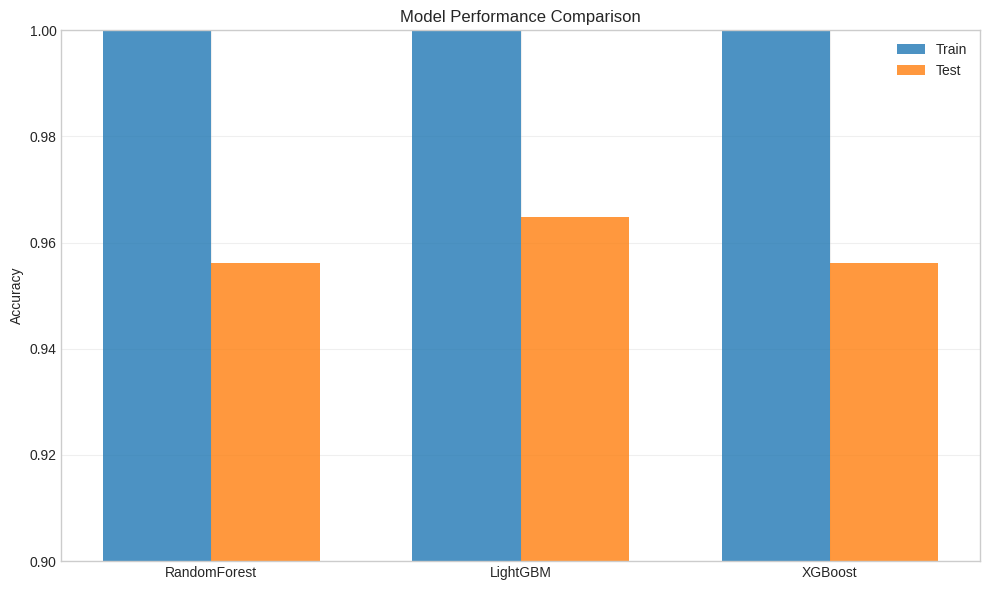

In [5]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_results))
width = 0.35

ax.bar(x - width/2, df_results['Train Accuracy'], width, label='Train', alpha=0.8)
ax.bar(x + width/2, df_results['Test Accuracy'], width, label='Test', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Model'])
ax.legend()
ax.set_ylim([0.9, 1.0])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**可視化の重要性**：
データや結果をグラフで表示すると、以下のことが分かります：
- モデル間の性能差
- 訓練精度とテスト精度のギャップ（過学習の度合い）
- どのモデルが最も安定しているか

「百聞は一見にしかず」です。数字だけでなく、
グラフで見ると直感的に理解できます。

## Part 3: Early Stopping - 過学習を自動で防ぐ！

### Early Stoppingとは？

**Early Stopping（早期停止）** は、過学習を防ぐための最も重要なテクニックの一つです。

```
┌─────────────────────────────────────────────────────────────────────┐
│                    Early Stoppingの動作原理                         │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  精度                                                               │
│   ▲                                                                 │
│   │                          ┌─────────────────┐                    │
│   │        ●──●─●         │ この点で停止！   │                    │
│   │       ╱        ╲───●   └────────┬────────┘                    │
│   │      ╱          テスト精度▼が下がり始める                       │
│   │     ╱                                                           │
│   │    ╱    ●──●──●──●──●──●──●──●                              │
│   │   ╱                    訓練精度は上がり続ける                    │
│   │  ╱                                                              │
│   │ ╱                                                               │
│   │╱                                                                │
│   └──────────────────────────────────────────────────────────▶     │
│                          木の数（イテレーション）                    │
│                                                                     │
│  【3つの領域】                                                      │
│   ① Underfitting: まだ学習が足りない                                │
│   ② Sweet Spot: 最適な複雑さ ← ここで止めたい！                     │
│   ③ Overfitting: 訓練データに過剰適合                               │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### なぜ3分割（Train/Validation/Test）が必要か？

```
【データ分割の理由】

元データ 100%
    │
    ├── Training Set (60-70%)
    │       └── モデルの学習に使用
    │
    ├── Validation Set (15-20%)
    │       └── Early Stoppingの監視に使用
    │           「いつ止めるか」を決める
    │
    └── Test Set (15-20%)
            └── 最終評価に使用（一度だけ）
                本当の汎化性能を測る

【重要】
- Validationセットは「学習中に見る」のでモデルが間接的に学習する
- TestセットはEarly Stoppingの判断にも使わない
- Testセットで評価した精度が「本当の実力」
```

### Early Stoppingのパラメータ

| パラメータ | 意味 | 推奨値 |
|-----------|------|--------|
| `eval_set` | 監視するデータセット | 検証データ |
| `stopping_rounds` | 改善しない許容回数 | 50-100 |
| `eval_metric` | 監視する指標 | 'logloss', 'auc' |

**`stopping_rounds`（patience）の考え方**：

```
stopping_rounds=50 の場合：

木100: 検証精度 0.95 ← 最高記録！
木101: 検証精度 0.94
木102: 検証精度 0.94
  ...
木149: 検証精度 0.93
木150: 検証精度 0.93 ← 50回連続で改善なし → 停止！

→ 最終的に木100の状態のモデルを採用
```

**なぜ即座に止めないのか？**
- 一時的に精度が下がっても、その後回復することがある
- 局所解から抜け出す時間を与える
- 小さすぎると早まった停止、大きすぎると過学習

In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Split validation set from training set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Dataset split:")
print(f"  Training: {len(X_train_sub)} samples")
print(f"  Validation: {len(X_val)} samples")
print(f"  Test: {len(X_test)} samples")

Dataset split:
  Training: 364 samples
  Validation: 91 samples
  Test: 114 samples


**Early Stoppingとは？**

Early Stoppingは、過学習を防ぐ強力なテクニックです：

1. 学習中に検証データ（Validation set）で精度を監視
2. 検証精度が改善しなくなったら、学習を自動で停止
3. 最も良かった時点のモデルを採用

**メリット**：
- 過学習を防げる
- 無駄な学習時間を削減できる
- ハイパーパラメータ調整が楽になる

In [7]:
# ============================================================
# [コードの説明]
# ============================================================

# LightGBM with early stopping
lgbm_model = LGBMClassifier(
    n_estimators=1000,  # 大きめに設定（早期終了するので問題ない）
    random_state=42,
    verbose=-1
)

# Fit with early stopping
lgbm_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

print(f"\nLightGBM Early Stopping Results:")
print(f"  Best iteration: {lgbm_model.best_iteration_}")
print(f"  Total iterations set: {lgbm_model.n_estimators}")
print(f"  Stopped early at: {lgbm_model.best_iteration_} trees")
print(f"\n  Test Accuracy: {lgbm_model.score(X_test, y_test):.4f}")


LightGBM Early Stopping Results:
  Best iteration: 34
  Total iterations set: 1000
  Stopped early at: 34 trees

  Test Accuracy: 0.9561


**Early Stoppingの結果**：

- `n_estimators=1000` に設定したが、実際には途中で停止
- `stopping_rounds=50` は「50回改善しなかったら停止」という意味
- 最適な木の数が自動で見つかる

これにより、過学習を防ぎつつ、最高の性能を引き出せます。

In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# XGBoost with early stopping
xgb_model = XGBClassifier(
    early_stopping_rounds=50,
   
    n_estimators=1000,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(f"\nXGBoost Early Stopping Results:")
print(f"  Best iteration: {xgb_model.best_iteration}")
print(f"  Total iterations set: {xgb_model.n_estimators}")
print(f"  Stopped early at: {xgb_model.best_iteration} trees")
print(f"\n  Test Accuracy: {xgb_model.score(X_test, y_test):.4f}")


XGBoost Early Stopping Results:
  Best iteration: 11
  Total iterations set: 1000
  Stopped early at: 11 trees

  Test Accuracy: 0.9386


**LightGBM vs XGBoostのEarly Stopping**：

どちらも同じ概念ですが、書き方が少し違います：

- **LightGBM**: `callbacks=[lgb.early_stopping(...)]`
- **XGBoost**: `early_stopping_rounds=...`

どちらも`eval_set`に検証データを渡すことで動作します。

## Part 4: Learning Curves - 学習の推移を可視化

### なぜ学習曲線を見るのか？

学習曲線は「モデルの健康診断」です。グラフを見るだけで：

1. **過学習しているか？** → Train/Testのギャップ
2. **学習が足りているか？** → まだ精度が上がっているか
3. **最適な木の数は？** → Test精度のピーク位置

```
┌─────────────────────────────────────────────────────────────────────┐
│                     学習曲線の4パターン                             │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【1. 理想的な学習】          【2. 過学習】                          │
│   精度▲                        精度▲                               │
│      │  ──────── Train          │  ──────────── Train (1.0)        │
│      │  ──────── Test           │  ────────╲                       │
│      │ ╱                        │ ╱         ╲──── Test             │
│      │╱                         │╱                                  │
│      └────────▶ 木の数          └────────▶ 木の数                  │
│   Trainとの差が小さい           Train=1.0, ギャップ大               │
│   → Good!                       → Early Stopping必要               │
│                                                                     │
│  【3. 学習不足】               【4. データ不足】                     │
│   精度▲                        精度▲                               │
│      │        ╱─ Train          │  ──── Train                       │
│      │       ╱                  │  ──── Test（両方低い）            │
│      │  ────╱── Test            │                                   │
│      │ ╱                        │                                   │
│      └────────▶ 木の数          └────────▶ 木の数                  │
│   まだ上昇中                    両方とも頭打ち                       │
│   → もっと木を増やす            → データを増やすか特徴量を追加      │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### 学習曲線から読み取れること

| 症状 | 診断 | 処方 |
|------|------|------|
| Train高, Test低 | 過学習 | Early Stopping, 正則化, データ追加 |
| 両方低い | モデル能力不足 | 木を深く, 特徴量追加 |
| 両方高い（差小） | 理想的 | そのまま使用 |
| Testがまだ上昇中 | 学習不足 | 木を増やす |

### 学習率（learning_rate）との関係

```
【学習率と木の数のトレードオフ】

学習率 = 各木の貢献度を調整するパラメータ

learning_rate=0.1 の場合:
    新予測 = 旧予測 + 0.1 × 木の予測
    → 少しずつ学習 → 多くの木が必要
    → 精度は高くなりやすい

learning_rate=1.0 の場合:
    新予測 = 旧予測 + 1.0 × 木の予測
    → 大きく学習 → 少ない木で収束
    → 過学習しやすい

【実践的な指針】
- 学習率を下げる → 木の数を増やす → 精度向上
- 学習率 0.01〜0.1 が一般的
- 計算時間との兼ね合いで調整
```

In [9]:
# ============================================================
# [コードの説明]
# ============================================================

# Train models and track performance
n_trees_range = range(10, 501, 10)

lgbm_train_scores = []
lgbm_test_scores = []
xgb_train_scores = []
xgb_test_scores = []

for n_trees in n_trees_range:
    # LightGBM
    lgbm = LGBMClassifier(n_estimators=n_trees, random_state=42, verbose=-1)
    lgbm.fit(X_train, y_train)
    lgbm_train_scores.append(lgbm.score(X_train, y_train))
    lgbm_test_scores.append(lgbm.score(X_test, y_test))
    
    # XGBoost
    xgb_clf = XGBClassifier(n_estimators=n_trees, random_state=42, eval_metric='logloss')
    xgb_clf.fit(X_train, y_train)
    xgb_train_scores.append(xgb_clf.score(X_train, y_train))
    xgb_test_scores.append(xgb_clf.score(X_test, y_test))

print("Learning curve data collected.")

Learning curve data collected.


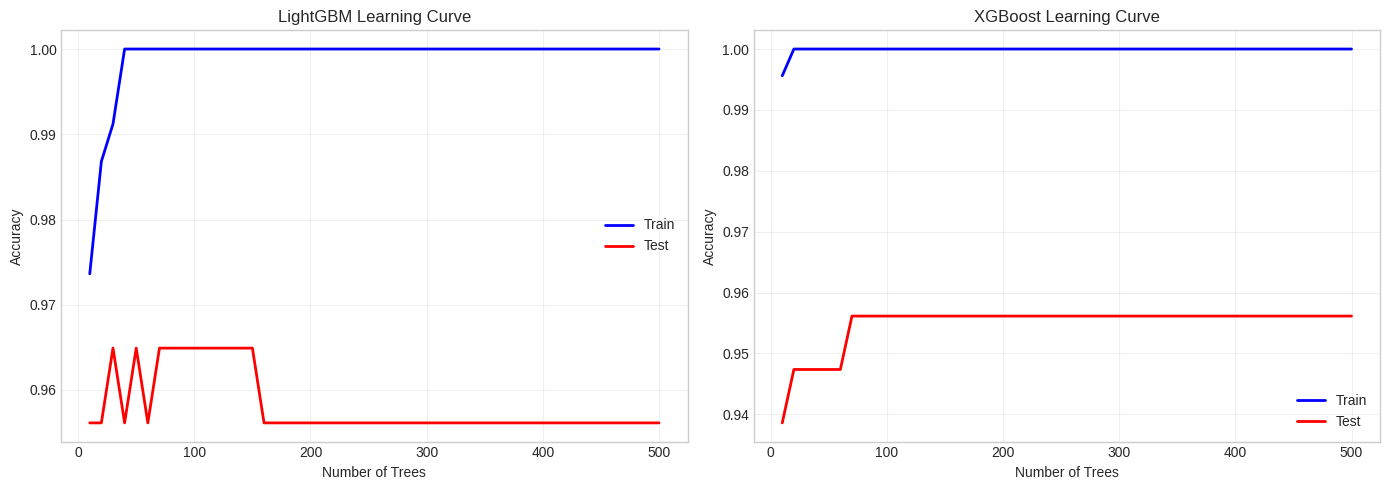

In [10]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LightGBM
axes[0].plot(n_trees_range, lgbm_train_scores, 'b-', label='Train', linewidth=2)
axes[0].plot(n_trees_range, lgbm_test_scores, 'r-', label='Test', linewidth=2)
axes[0].set_xlabel('Number of Trees')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('LightGBM Learning Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# XGBoost
axes[1].plot(n_trees_range, xgb_train_scores, 'b-', label='Train', linewidth=2)
axes[1].plot(n_trees_range, xgb_test_scores, 'r-', label='Test', linewidth=2)
axes[1].set_xlabel('Number of Trees')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('XGBoost Learning Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**学習曲線の読み方**：

1. **訓練精度（青線）**:
   - 木の数が増えるほど上昇
   - 最終的に1.0（完璧）に近づく

2. **テスト精度（赤線）**:
   - 最初は上昇するが、途中で頭打ちか低下
   - 低下し始めたら過学習のサイン

3. **最適な木の数**:
   - テスト精度が最大になる点
   - Early Stoppingで自動的に見つけられる

**LightGBM vs XGBoost**:
- どちらも似た挙動を示す
- データセットによってどちらが良いかは異なる
- 両方試して比較するのがベストプラクティス

## Part 5: Speed Comparison - 速度を比較

### なぜ速度が重要なのか？

機械学習の実務では、**速度は精度と同じくらい重要**です：

1. **ハイパーパラメータ調整**: GridSearchCVで何百回も学習を繰り返す
2. **特徴量エンジニアリング**: 試行錯誤の回数が成果を決める
3. **プロダクション**: 推論時間がユーザー体験に直結
4. **コスト**: クラウドの計算リソースは有料

```
【速度が10倍違うとどうなるか？】

1回の学習が1分 vs 10分 の場合：

GridSearchCV (100パターン × 5-fold = 500回):
  - 1分/回 → 500分 = 約8時間
  - 10分/回 → 5000分 = 約3日半

→ 速いモデルなら「今日中に試せる」
→ 遅いモデルだと「週末を待つしかない」
```

### なぜLightGBMは速いのか？

LightGBMの高速化技術を詳しく見てみましょう：

```
┌─────────────────────────────────────────────────────────────────────┐
│                    LightGBMの高速化技術                             │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【1. Histogram-based Splitting】                                   │
│                                                                     │
│  従来: 全ての値で分割点を探索                                       │
│        1.2, 1.5, 1.7, 2.3, 2.8, 3.1, ...（N通り）                 │
│                                                                     │
│  LightGBM: 値をビンに離散化                                         │
│        [1-2] [2-3] [3-4] ...（256ビン程度）                        │
│                                                                     │
│  → メモリ使用量: float64 → uint8 に削減                            │
│  → 計算量: O(N) → O(bins) に削減                                   │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【2. GOSS (Gradient-based One-Side Sampling)】                     │
│                                                                     │
│  勾配が大きいサンプル = 「まだ学習が必要」                          │
│  勾配が小さいサンプル = 「もう十分学習済み」                        │
│                                                                     │
│  → 勾配の大きいサンプルを優先的にサンプリング                       │
│  → データ量を減らしても精度を維持                                   │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【3. EFB (Exclusive Feature Bundling)】                            │
│                                                                     │
│  排他的な特徴量を束ねる                                             │
│  例: OneHotEncodingされた特徴量                                     │
│       [1,0,0], [0,1,0], [0,0,1] → 同時に1にならない                │
│                                                                     │
│  → 3特徴量を1特徴量に圧縮                                          │
│  → 次元数を大幅削減                                                 │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### 速度 vs 精度のトレードオフ

| 観点 | LightGBM | XGBoost | Random Forest |
|------|----------|---------|---------------|
| 訓練速度 | ⭐⭐⭐ | ⭐⭐ | ⭐ |
| 推論速度 | ⭐⭐⭐ | ⭐⭐ | ⭐⭐ |
| メモリ効率 | ⭐⭐⭐ | ⭐⭐ | ⭐ |
| 精度 | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐ |
| 過学習耐性 | ⭐⭐ | ⭐⭐ | ⭐⭐⭐ |

**実務での選択基準**：
- プロトタイプ開発 → LightGBM（高速な試行錯誤）
- 本番環境（安定性重視）→ XGBoost
- ベースライン作成 → Random Forest（シンプル）

In [11]:
# ============================================================
# [コードの説明]
# ============================================================

import time

# Larger dataset for speed comparison
from sklearn.datasets import make_classification

X_large, y_large = make_classification(
    n_samples=10000,
    n_features=50,
    n_informative=30,
    n_classes=2,
    random_state=42
)

X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(
    X_large, y_large, test_size=0.2, random_state=42
)

print("Large dataset created:")
print(f"  Training: {len(X_train_large)} samples")
print(f"  Features: {X_large.shape[1]}")

Large dataset created:
  Training: 8000 samples
  Features: 50


In [12]:
# Compare training speed
models_speed = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

speed_results = []

for name, model in models_speed.items():
    start_time = time.time()
    model.fit(X_train_large, y_train_large)
    elapsed_time = time.time() - start_time
    
    test_acc = model.score(X_test_large, y_test_large)
    
    speed_results.append({
        'Model': name,
        'Training Time (s)': elapsed_time,
        'Test Accuracy': test_acc
    })

df_speed = pd.DataFrame(speed_results)
print("\n" + "="*60)
print("Speed Comparison (10,000 samples, 50 features)")
print("="*60)
print(df_speed.to_string(index=False))


Speed Comparison (10,000 samples, 50 features)
       Model  Training Time (s)  Test Accuracy
RandomForest           0.468591         0.9310
    LightGBM           0.359325         0.9425
     XGBoost           0.340132         0.9495


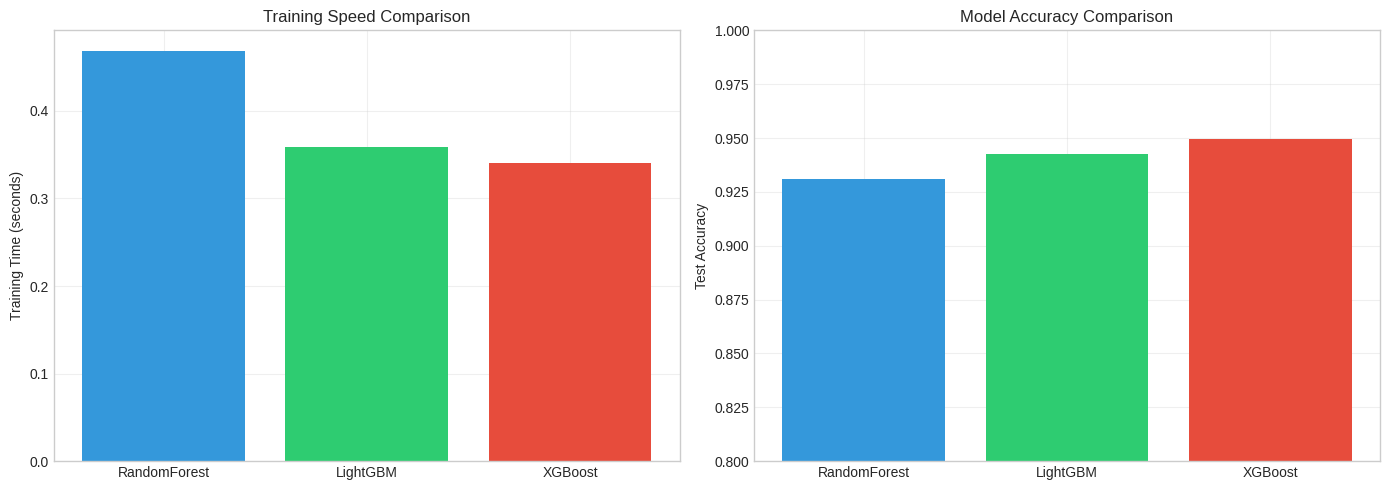

In [13]:
# Visualize speed comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training time
axes[0].bar(df_speed['Model'], df_speed['Training Time (s)'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Training Time (seconds)')
axes[0].set_title('Training Speed Comparison')
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].bar(df_speed['Model'], df_speed['Test Accuracy'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Model Accuracy Comparison')
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**速度比較の結果**：

一般的な傾向：
1. **LightGBM**: 最も高速（数倍速いことも）
2. **XGBoost**: 中程度の速度
3. **RandomForest**: 相対的に遅い（特にデータが大きい場合）

**重要なポイント**：
- LightGBMは「軽量」の名の通り、非常に高速
- データサイズが大きいほど、速度差が顕著
- 精度はどれも高い水準で、速度とのトレードオフを考える

**実務では**：
- プロトタイピング: LightGBM（高速実験）
- 本番環境: 速度と精度のバランスで選択
- Kaggle: 両方試してアンサンブル

## Part 6: Feature Importance - 重要な特徴量を知る

### なぜFeature Importanceが重要なのか？

**モデルの解釈性**は、実務で非常に重要です：

1. **ビジネス上の意思決定**: 「なぜこの予測になったか」を説明できる
2. **特徴量エンジニアリング**: 重要な特徴量から派生変数を作る
3. **データ収集の優先度**: 重要な特徴量に関連するデータを増やす
4. **モデルの検証**: 「おかしな特徴量」が重要になっていないか確認

```
┌─────────────────────────────────────────────────────────────────────┐
│                  Feature Importanceの3つの計算方法                  │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【1. Split（分割回数）】                                           │
│                                                                     │
│  その特徴量で分割された回数をカウント                               │
│                                                                     │
│  例: age特徴量が全木で合計100回分割に使われた → importance=100      │
│                                                                     │
│  メリット: シンプルで理解しやすい                                   │
│  デメリット: カーディナリティ（値の種類数）が高い特徴量が有利       │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【2. Gain（情報利得）】 ← 推奨！                                   │
│                                                                     │
│  その特徴量による分割がもたらした損失関数の減少量の合計             │
│                                                                     │
│  例: age特徴量での分割が、損失を合計50減少させた → importance=50    │
│                                                                     │
│  メリット: 実際の貢献度を反映                                       │
│  デメリット: 計算がやや複雑                                         │
│                                                                     │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【3. Permutation Importance（順列重要度）】                        │
│                                                                     │
│  特徴量の値をシャッフルして精度がどれだけ下がるか測定               │
│                                                                     │
│  例: age特徴量をシャッフル → 精度が10%低下 → importance=0.10       │
│                                                                     │
│  メリット: モデルに依存しない、相関を考慮                           │
│  デメリット: 計算コストが高い                                       │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### Feature Importanceの注意点

```
【よくある落とし穴】

⚠️ 相関のある特徴量:
   age と birth_year は強く相関
   → 重要度が両方に分散してしまう
   → 実際より低く見えることがある

⚠️ カテゴリカルエンコーディング:
   OneHotEncodingすると特徴量が増える
   → 重要度が分散してしまう
   → 元のカテゴリ単位で合計するのがベター

⚠️ スケールの影響:
   GBDTはスケール不変だが、
   他の手法と比較する際は注意

【ベストプラクティス】
1. 複数の重要度指標を比較する
2. ドメイン知識と照らし合わせる
3. SHAP値で詳細に分析（発展編）
```

### Feature Importanceの活用パターン

| 活用シーン | やること | 期待効果 |
|-----------|---------|---------|
| 特徴量選択 | 下位50%を削除 | モデル軽量化、過学習防止 |
| 新特徴量作成 | 上位特徴量の組み合わせ | 精度向上 |
| バグ発見 | 異常に高い特徴量を調査 | データリーク検出 |
| ビジネス理解 | 上位特徴量を報告 | 意思決定支援 |

In [14]:
# ============================================================
# [コードの説明]
# ============================================================

# Train models on original dataset
lgbm_final = LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
lgbm_final.fit(X_train, y_train)

xgb_final = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_final.fit(X_train, y_train)

# Get feature importances
lgbm_importances = pd.DataFrame({
    'feature': data.feature_names,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importances = pd.DataFrame({
    'feature': data.feature_names,
    'importance': xgb_final.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Important Features (LightGBM):")
print(lgbm_importances.head(10).to_string(index=False))

Top 10 Important Features (LightGBM):
             feature  importance
       worst texture         238
worst concave points         220
      worst symmetry         142
 mean concave points         129
    worst smoothness         125
        mean texture         122
        worst radius         112
     worst perimeter         111
          area error         108
          worst area          91


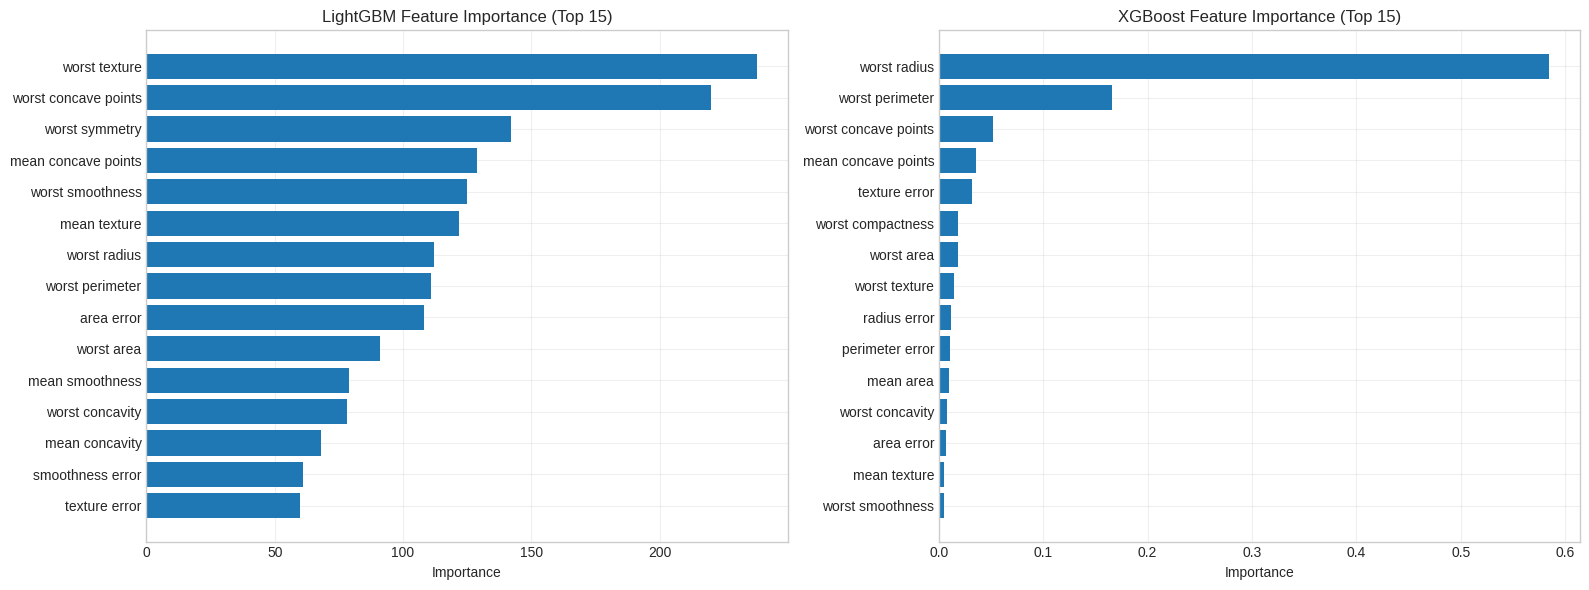

In [15]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LightGBM
top_n = 15
axes[0].barh(range(top_n), lgbm_importances['importance'].head(top_n))
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(lgbm_importances['feature'].head(top_n))
axes[0].invert_yaxis()
axes[0].set_xlabel('Importance')
axes[0].set_title('LightGBM Feature Importance (Top 15)')
axes[0].grid(True, alpha=0.3)

# XGBoost
axes[1].barh(range(top_n), xgb_importances['importance'].head(top_n))
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(xgb_importances['feature'].head(top_n))
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost Feature Importance (Top 15)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Feature Importanceの活用法**：

1. **モデルの解釈**:
   - どの特徴量が予測に重要か理解できる
   - ビジネス上の意思決定に役立つ

2. **特徴量選択**:
   - 重要度の低い特徴量を削除してモデルを簡素化
   - 過学習を防ぐ
   - 推論速度を向上

3. **新しい特徴量の発見**:
   - 重要な特徴量から派生特徴量を作成
   - より良いモデルへの手がかり

**LightGBM vs XGBoost**:
- 重要度の計算方法が若干異なる
- 上位の特徴量はだいたい一致することが多い
- 両方見て総合的に判断するのが良い

## Part 7: Cross-Validation with GBDT

### GBDTでのCross-Validationの注意点

GBDTでCross-Validationを行う際、いくつかの重要なポイントがあります：

```
┌─────────────────────────────────────────────────────────────────────┐
│                GBDTでのCV: Early Stoppingとの組み合わせ             │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  【問題】                                                           │
│  cross_val_score() では Early Stopping が使えない                   │
│  → 各Foldで異なる最適木数になる可能性                               │
│                                                                     │
│  【解決策1: 固定のn_estimators】                                    │
│  事前に適切な木の数を決めてCVを実行                                 │
│  → 簡単だが、最適ではない可能性                                     │
│                                                                     │
│  【解決策2: Nested CV（入れ子CV）】                                 │
│  内側ループでEarly Stoppingして最適な木数を決定                     │
│  外側ループで性能を評価                                             │
│  → より正確だが、計算コストが高い                                   │
│                                                                     │
│  【解決策3: ライブラリ組み込みCV】                                  │
│  lgb.cv() や xgb.cv() を使用                                       │
│  → Early Stopping対応のCV                                          │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

### Cross-Validationの結果の見方

```
【結果の解釈】

平均CV精度: 0.970
標準偏差: 0.017

これは「真の精度は 0.970 ± 0.034 (2σ) の範囲にある」ことを示す

【良い結果の目安】
✅ 平均が高い（タスクによるが80%以上）
✅ 標準偏差が小さい（< 0.05程度）
✅ Min/Maxの差が小さい

【悪い結果の兆候】
⚠️ 標準偏差が大きい → モデルが不安定
⚠️ 一部のFoldだけ極端に低い → データに問題がある可能性
⚠️ 全Foldで100%近い → データリークの疑い
```

### 実務でのCV戦略

| シチュエーション | 推奨CV戦略 |
|-----------------|-----------|
| データが十分（> 10,000） | 5-Fold CV |
| データが少ない（< 1,000） | 10-Fold CV または Leave-One-Out |
| クラス不均衡がある | Stratified K-Fold |
| 時系列データ | TimeSeriesSplit |
| グループがある（同一ユーザーなど） | GroupKFold |

In [16]:
# ============================================================
# [コードの説明]
# ============================================================

# Cross-validation for all models
from sklearn.model_selection import cross_val_score

models_cv = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}

print("\n" + "="*60)
print("Cross-Validation Results (5-Fold)")
print("="*60)

cv_results = []

for name, model in models_cv.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    cv_results.append({
        'Model': name,
        'Mean CV Score': scores.mean(),
        'Std CV Score': scores.std(),
        'Min Score': scores.min(),
        'Max Score': scores.max()
    })
    
    print(f"\n{name}:")
    print(f"  CV Scores: {scores}")
    print(f"  Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

df_cv = pd.DataFrame(cv_results)
print("\n" + df_cv.to_string(index=False))


Cross-Validation Results (5-Fold)



RandomForest:
  CV Scores: [0.92105263 0.93859649 0.98245614 0.96491228 0.97345133]
  Mean: 0.9561 (+/- 0.0457)



LightGBM:
  CV Scores: [0.93859649 0.96491228 0.98245614 0.98245614 0.98230088]
  Mean: 0.9701 (+/- 0.0343)



XGBoost:
  CV Scores: [0.97368421 0.95614035 1.         0.96491228 0.97345133]
  Mean: 0.9736 (+/- 0.0294)

       Model  Mean CV Score  Std CV Score  Min Score  Max Score
RandomForest       0.956094      0.022839   0.921053   0.982456
    LightGBM       0.970144      0.017167   0.938596   0.982456
     XGBoost       0.973638      0.014679   0.956140   1.000000


**Cross-Validationの重要性**：

単一のテストセットでの評価は、運が良いだけかもしれません。
Cross-Validationで複数の分割パターンで評価することで、
**本当の実力**を測定できます。

**結果の見方**：
- **Mean CV Score**: 平均精度（高いほど良い）
- **Std CV Score**: 標準偏差（小さいほど安定）
- **Min/Max Score**: 最悪/最良のケース

実務では、平均だけでなく標準偏差も重要です。
標準偏差が大きいモデルは、データによって性能が不安定です。

## まとめ

### 🎯 このノートブックで学んだこと

```
┌─────────────────────────────────────────────────────────────────────┐
│                        GBDT完全マスターマップ                        │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│  ① GBDTの原理                                                       │
│     └── Boosting: 前の木の「間違い」を修正する木を順次学習          │
│     └── 勾配降下法: 損失関数の勾配方向に予測を更新                  │
│     └── Baggingとの違い: 並列 vs 順次                               │
│                                                                     │
│  ② Scikit-learn API                                                 │
│     └── fit(), predict(), score() がそのまま使える                 │
│     └── Pipeline, GridSearchCV との互換性                           │
│                                                                     │
│  ③ Early Stopping                                                   │
│     └── 検証データで監視して過学習を防ぐ                            │
│     └── 最適な木の数を自動で決定                                    │
│     └── stopping_rounds = 50-100 が目安                             │
│                                                                     │
│  ④ 学習曲線                                                         │
│     └── Train/Testのギャップで過学習を診断                          │
│     └── 学習率と木の数のトレードオフ                                │
│                                                                     │
│  ⑤ 速度と性能                                                       │
│     └── LightGBM: 最速（Histogram, Leaf-wise）                      │
│     └── XGBoost: 安定（Level-wise）                                 │
│                                                                     │
│  ⑥ Feature Importance                                               │
│     └── 3種類: Split, Gain, Permutation                             │
│     └── Gainが最も実用的                                            │
│                                                                     │
└─────────────────────────────────────────────────────────────────────┘
```

---

### 📋 GBDTクイックリファレンス

#### LightGBM基本テンプレート

```python
from lightgbm import LGBMClassifier
import lightgbm as lgb

# 基本的な使い方
model = LGBMClassifier(
    n_estimators=1000,       # 大きめに設定（Early Stoppingで調整）
    learning_rate=0.05,      # 小さめで精度向上
    max_depth=-1,            # 制限なし（num_leavesで制御）
    num_leaves=31,           # 複雑さの制御
    random_state=42,
    verbose=-1               # 出力を抑制
)

# Early Stopping付き学習
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# 最適な木の数を確認
print(f"Best iteration: {model.best_iteration_}")
```

#### XGBoost基本テンプレート

```python
from xgboost import XGBClassifier

# 基本的な使い方
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,             # XGBoostはmax_depthで制御
    early_stopping_rounds=50,
    eval_metric='logloss',
    random_state=42
)

# Early Stopping付き学習
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 最適な木の数を確認
print(f"Best iteration: {model.best_iteration}")
```

---

### 🔧 ハイパーパラメータ早見表

| パラメータ | LightGBM | XGBoost | 説明 | 推奨範囲 |
|-----------|----------|---------|------|---------|
| 木の数 | `n_estimators` | `n_estimators` | Early Stoppingで調整 | 100-10000 |
| 学習率 | `learning_rate` | `learning_rate` | 小さいほど精度↑速度↓ | 0.01-0.3 |
| 木の深さ | `max_depth` | `max_depth` | 大きいほど複雑 | 3-10 |
| 葉の数 | `num_leaves` | - | LightGBM特有 | 20-100 |
| 正則化(L1) | `reg_alpha` | `reg_alpha` | 過学習防止 | 0-10 |
| 正則化(L2) | `reg_lambda` | `reg_lambda` | 過学習防止 | 0-10 |
| サブサンプリング | `subsample` | `subsample` | ランダム性追加 | 0.6-1.0 |
| 特徴量サンプリング | `colsample_bytree` | `colsample_bytree` | ランダム性追加 | 0.6-1.0 |

---

### ✅ GBDTチェックリスト

#### データ準備
- [ ] 欠損値の確認（GBDTは欠損値を扱えるが、確認は必要）
- [ ] カテゴリ変数の処理（次章で詳しく学習）
- [ ] Train/Validation/Test の3分割

#### モデル学習
- [ ] Early Stoppingの設定
- [ ] 学習曲線の可視化
- [ ] 過学習の確認

#### 評価・分析
- [ ] Cross-Validationで安定性確認
- [ ] Feature Importanceの確認
- [ ] ドメイン知識との整合性チェック

---

### 🚀 次のステップ

**Notebook 14: CatBoostとカテゴリ変数の攻略** では：
- カテゴリ変数を直接扱えるCatBoost
- Target Encodingの仕組み
- OneHotEncodingとの比較

**さらに学ぶために**：
- SHAP値によるモデル解釈（発展編）
- Optuna/Hyperoptによるハイパーパラメータ最適化
- LightGBM/XGBoostのネイティブAPI

---

### 🎉 お疲れ様でした！

GBDTはテーブルデータで最も強力なアルゴリズムです。
このノートブックで学んだことを活かして、
次のコンペやプロジェクトで実践してみましょう！

### ⚠️ よくあるエラー #1: LightGBMのインストール失敗

LightGBMのインストールで"Microsoft Visual C++が必要"エラーが出ることがあります。

**原因:**
1. Windows環境でC++コンパイラがインストールされていない
2. ビルド済みバイナリが見つからない

**✅ 解決法:**

```bash
# Windows: condaを使う方法（推奨）
conda install -c conda-forge lightgbm

# またはpre-builtホイールを使う
pip install lightgbm --prefer-binary

# macOS/Linux: 通常のpipで問題なし
pip install lightgbm
```

---

### ⚠️ よくあるエラー #2: Early Stoppingが効かない

Early Stoppingを設定したのに、全ての木が学習されてしまう。

**原因:**
1. `eval_set`を渡していない
2. `eval_metric`が正しく設定されていない

**✅ 解決法:**

```python
# ❌ 間違い: eval_setがない
model.fit(X_train, y_train)

# ✅ 正しい: eval_setを渡す
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)
```

---

---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: LightGBMとXGBoostの最大の利点は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: Scikit-learnと同じAPIで、より高い精度と速度が得られること

LightGBMとXGBoostは、Scikit-learnの`RandomForestClassifier`などと全く同じ使い方ができます。そのため、既存のコードを簡単に置き換えられます。さらに、テーブルデータでは通常、より高い精度を達成でき、特にLightGBMは非常に高速です。

</details>

---

### Q2: Early Stoppingの役割は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 過学習を防ぎ、最適な木の数を自動で見つける

Early Stoppingは、検証データの性能を監視しながら学習を進め、性能が改善しなくなったら自動で学習を停止します。これにより、過学習を防ぎつつ、最適なモデルを得られます。また、無駄な計算時間も節約できます。

</details>

---

### Q3: Feature Importanceを見ることで何が分かりますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: どの特徴量が予測に重要か、モデルの解釈ができる

Feature Importanceは、各特徴量が予測にどれだけ貢献しているかを示します。これにより、モデルの解釈が可能になり、重要でない特徴量を削除したり、重要な特徴量から新しい派生特徴量を作成したりできます。また、ビジネス上の意思決定にも役立ちます。

</details>

---

</details>

---

## ➡️ 次のステップ

### 学習を続ける

次は **Notebook 14: CatBoostとカテゴリ変数の攻略** へ進みましょう！

CatBoostは、カテゴリ変数（"male"/"female"のような文字列データ）を
OneHotEncodingなしで直接扱える革新的なライブラリです。

### 復習が必要な場合

- **Notebook 05: Tree and Ensemble Models**
- **Notebook 03: Model Evaluation Metrics**

### さらに学ぶために

**公式ドキュメント:**
- LightGBM: https://lightgbm.readthedocs.io/
- XGBoost: https://xgboost.readthedocs.io/

**書籍:**
- "Hands-On Gradient Boosting with XGBoost and scikit-learn"

**Kaggleで実践:**
- Titanic Competition
- House Prices Competition

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！